In [88]:
import edi_pyagnostics.edirequest as dia
import pandas as pd
import numpy as np

In [89]:
new = dia.load_new_request('2020-12-02', '2020-12-31')

In [90]:
old = dia.load_archived()

In [113]:
max(old.date)

'2020-11-25T07:46:58.688'

In [98]:
df = pd.concat([old, new])
df

,date,pkgid,action
0,2015-04-17T14:42:05.936,2100011003,createDataPackage
1,2015-04-17T15:43:26.172,210120002,createDataPackage
2,2015-04-17T15:43:26.771,2100392001,createDataPackage
3,2015-04-17T15:43:41.508,2100169002,createDataPackage
4,2015-04-17T15:43:45.55,2100010001,createDataPackage
...,...,...,...
293,2020-12-17T17:22:47.672,210548009,updateDataPackage
294,2020-12-17T17:23:45.75,210548039,updateDataPackage
295,2020-12-17T17:29:05.003,210548069,updateDataPackage
296,2020-12-17T17:29:50.171,210548084,updateDataPackage


In [99]:
df = dia.get_counts(df)

In [100]:
daily = dia.counts_to_daily(df, startdt='2020-01-01')
daily

,n_update,n_create,n_tot
date,,,
2020-01-07,3,0,0
2020-01-08,2,0,0
2020-01-09,0,0,0
2020-01-10,0,0,0
2020-01-11,0,0,0
...,...,...,...
2020-12-13,0,0,0
2020-12-14,1,0,0
2020-12-15,90,0,0


## Plot activity since last report (2020-01-01)


In [101]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

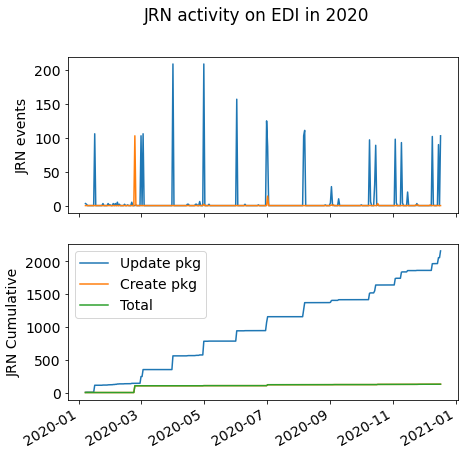

In [122]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily.index, daily.n_create.cumsum(), label='Create pkg')
ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI in 2020')
plt.legend()

import os
fig.savefig(os.path.expanduser("/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_EDI_2020_ann_rpt_{0}.png".format(now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [119]:
daily.n_create.sum()

127

In [104]:
daily.n_update.sum()

2159

## Plot 2020 activity excluding Met

In [109]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = dia.counts_to_daily(df.loc[nomet], startdt='2020-01-01')

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2020-01-07,3,0,0
2020-01-08,2,0,0
2020-01-09,0,0,0
2020-01-10,0,0,0
2020-01-11,0,0,0


### Total number of packages

In [110]:
daily_nomet.n_create.sum()

10

In [111]:
daily_nomet.n_update.sum()

62

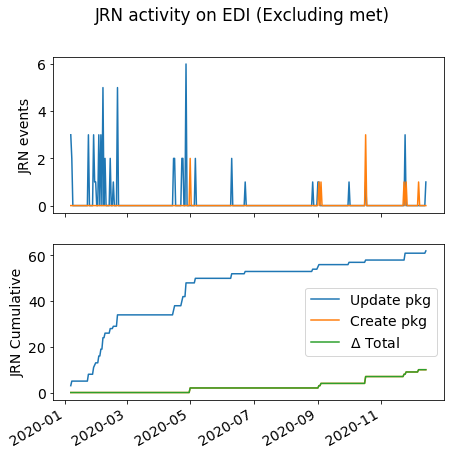

In [112]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "/Users/gmaurer/GD_gmaurer.jrn.lter/IM/figures/JRN_EDI_2020_ann_rpt_NoMet_{0}.png".format(now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [116]:
# Unique packages updated (excluding met)
rEDI = df.loc[df.index > '2019-12-31',]
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

2159
[210308001 210308002 210308003 210308005 210126003 210437031 210437016
 210437046 210437061 210437001 210437091 210437076 210437032 210437017
 210437047 210437062 210437002 210437092 210437077 210437033 210437018
 210437048 210437063 210437003 210437093 210437078 210437034 210437019
 210437049 210437064 210437094 210437004 210437079 210437106 210437035
 210437020 210437050 210437065 210437005 210437095 210437080 210437036
 210437021 210437051 210437066 210437006 210437096 210437081 210437037
 210437022 210437052 210437067 210437007 210437097 210437082 210437038
 210437023 210437053 210437068 210437008 210437098 210437083 210437039
 210437024 210437054 210437069 210437009 210437099 210437084 210437040
 210437025 210437055 210437070 210437010 210437100 210437085 210437041
 210437026 210437056 210437011 210437071 210437086 210437101 210437042
 210437027 210437057 210437072 210437012 210437087 210437102 210437043
 210437028 210437058 210437073 210437013 210437103 210437088 210437044
 

47

In [121]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

with open('tables_out/2020_annrpt_edi.md', 'w') as f:
    f.write(pkgtbl.to_markdown(tablefmt="grid"))

pkgtbl

,Total,Non-Met
New packages created,127,10
Package updates,2159,62
Unique package updates,270,47


In [55]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('2020AR_unique_EDI_updates.txt', 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437031',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437016',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437046',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437061',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437091',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437076',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437032',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437017',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437047',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210437062',